NoteBook link :
https://colab.research.google.com/drive/1f2YUJdVDcJsNYcStk7DjZ26TRRbrIHBo?usp=sharing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import pandas
from skimage.color import rgb2gray
from scipy import signal as sig
from scipy.ndimage import gaussian_filter

In [35]:
Harris = cv2.imread('harris.JPG', cv2.IMREAD_UNCHANGED)
Sl = cv2.imread('sl.jpg', cv2.IMREAD_UNCHANGED)
Sm = cv2.imread('sm.jpg', cv2.IMREAD_UNCHANGED)
Sr = cv2.imread('sr.jpg', cv2.IMREAD_UNCHANGED)

one = cv2.imread('1.jpg', cv2.IMREAD_UNCHANGED)
two = cv2.imread('2.jpg', cv2.IMREAD_UNCHANGED)
three = cv2.imread('3.jpg', cv2.IMREAD_UNCHANGED)

#Utils

In [3]:
def imshow(*args, title=None, figsize=20, to_rgb=True, fontsize=12):
    if isinstance(figsize, int):
        figsize = (figsize, figsize)
    images = args[0] if type(args[0]) is list else list(args)
    if to_rgb:
        images = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), images))
    if title is not None:
        assert len(title) == len(images), "Please provide a title for each image."
    plt.figure(figsize=figsize)
    for i in range(1, len(images)+1):
        plt.subplot(len(images), 1, i)
        if title is not None:
            plt.title(title[i-1], fontsize=fontsize)
        if images[i-1].ndim == 2:
            plt.imshow(images[i-1], cmap='gray')
        else:
            plt.imshow(images[i-1])
        plt.axis('off')

In [4]:
def normalize(a):
    if isinstance(a, list):
        return list(map(normalize, a))
    if isinstance(a, tuple):
        return tuple(normalize(list(a)))
    values = (((a - a.min()) / (a.max() - a.min())) * 255)
    values = values.astype('uint8')
    return values

In [283]:
def merge(img1, img2, matches, keypoints_l, keypoints_r):
  # Map each match to corresponding keypoints
  points = matches[:3]
  points = map(lambda m: (keypoints_l[m.queryIdx], keypoints_r[m.trainIdx]), points)

  # Map keypoints to coordinates
  pts_left = []
  pts_right = []
  for left_pt, right_pt in points:
      pts_left.append(list(left_pt.pt))
      pts_right.append(list(right_pt.pt))

  # Convert to numpy arrays
  pts_left = np.array(pts_left, dtype='float32')
  pts_right = np.array(pts_right, dtype='float32')

  # Create affine transformation matrix
  M = cv2.getAffineTransform(pts_right, pts_left)
  right_image_transformed = cv2.warpAffine(img1, M, (img1.shape[1], img1.shape[0]))

  # Create a mask
  mask = np.all((img2 == 0), axis=2)

  # Merge the images
  full_mask = np.repeat(mask.reshape(mask.shape+(1,)), 3, axis=2)
  result = img2 + (full_mask * right_image_transformed)
  imshow(result)

#7.1. Harris Corner Detector


##7.1.1

In [5]:
def harris_Corners(img, window_size):
    smooth = cv2.GaussianBlur(img,(3,3),0)
    gray = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
    grad_x =  cv2.Sobel(gray,-1,1,0,ksize = 3)
    grad_y =  cv2.Sobel(gray,-1,0,1,ksize = 3)

    h,w = grad_x.shape
    corners = np.zeros((h,w), dtype = np.float64)
    grad_x = grad_x.astype(np.float64)
    grad_y = grad_y.astype(np.float64)

    grad_xx = grad_x**2
    grad_xx = cv2.GaussianBlur(grad_xx,(3,3),0.5)
    grad_yy = grad_y**2
    grad_yy = cv2.GaussianBlur(grad_yy,(3,3),0.5)
    grad_xy = grad_x *grad_y
    grad_xy = cv2.GaussianBlur(grad_xy, (3,3), 0.5)



    offset = int(window_size/2)
    for i in range(offset, h-offset):
        for j in range(offset, w-offset):
            temp1 = grad_xx[i-offset:i+offset+1, j-offset:j+offset+1]
            temp2 = grad_yy[i-offset:i+offset+1, j-offset:j+offset+1]
            temp3 = grad_xy[i-offset:i+offset+1, j-offset:j+offset+1]
            a = np.sum(temp1)
            b = np.sum(temp2)
            c= np.sum(temp3)
            det  = a*b - (c*c)
            trace = a+b
            R = det - 0.04*(trace**2)
            corners[i,j] = R

    return corners


def draw_corners(corner, img, scale, marker_size):
  y, x = np.nonzero(corner > 0.4 * np.max(corner))
  for i in range(len(x)):
      x1 = int(x[i]); y1 = int(y[i])
      cv2.circle(img, (x1,y1), marker_size ,(0,0,255),-1)

  imshow(img,title=[f'scale = {scale}'], figsize=10)   

In [7]:
def corner_detector(image, i, w_size):
  img1 = image.copy()
  x , y ,channal= img1.shape
  
  img  = cv2.resize(img1, (int(y * i),int(x * i)))
  c = harris_Corners(img, w_size)
  draw_corners(c, img, i, int(i*3))

###4 different scales

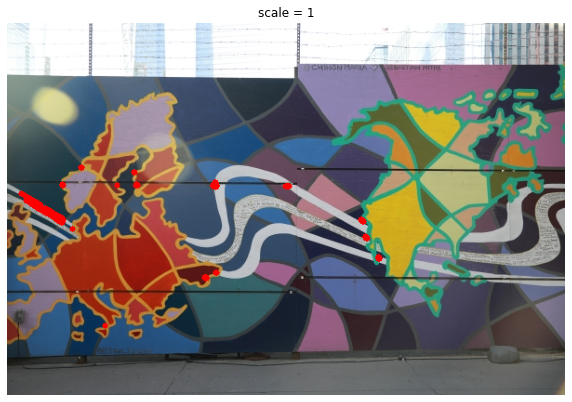

In [8]:
# Actual scale
corner_detector(Harris, 1, 5)

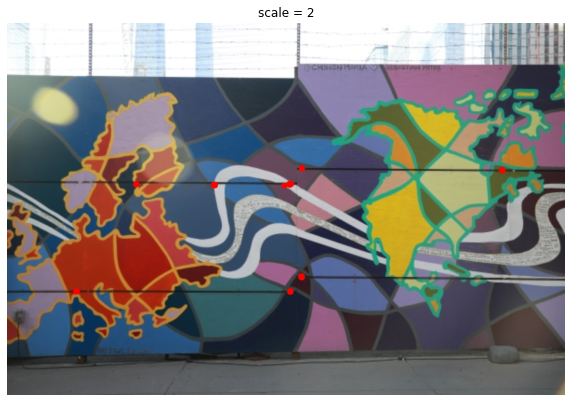

In [9]:
# Upper scale
corner_detector(Harris, 2, 5)

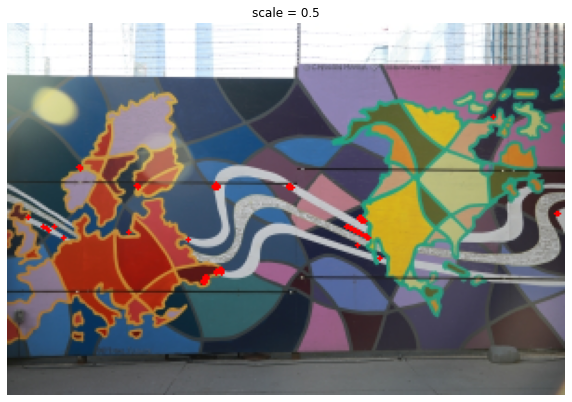

In [10]:
# Lower scale
corner_detector(Harris, 0.5, 3)

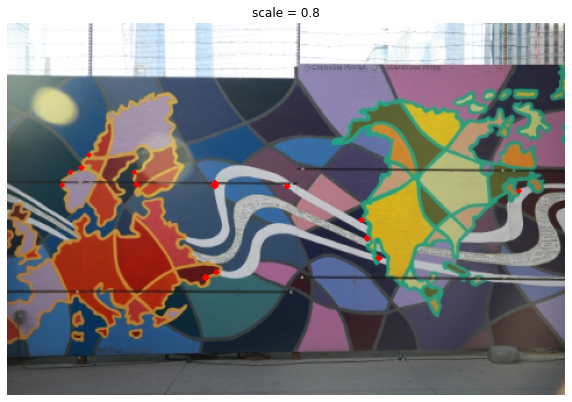

In [13]:
#Lower scale
corner_detector(Harris, 0.8, 3)

###Result

Based on the above results, the harris detector does not act the same in different scales of a picture. In Upper scales, it can not detect the key points where have been detected in actual scale.
Besides, in lower scales it detects the keypoints with high sensitivity while they would not be detected in actual scales.

Among the results above, the key points on the white curve in the middle of the picture and the points on the red region are the points that have detected in all scales.
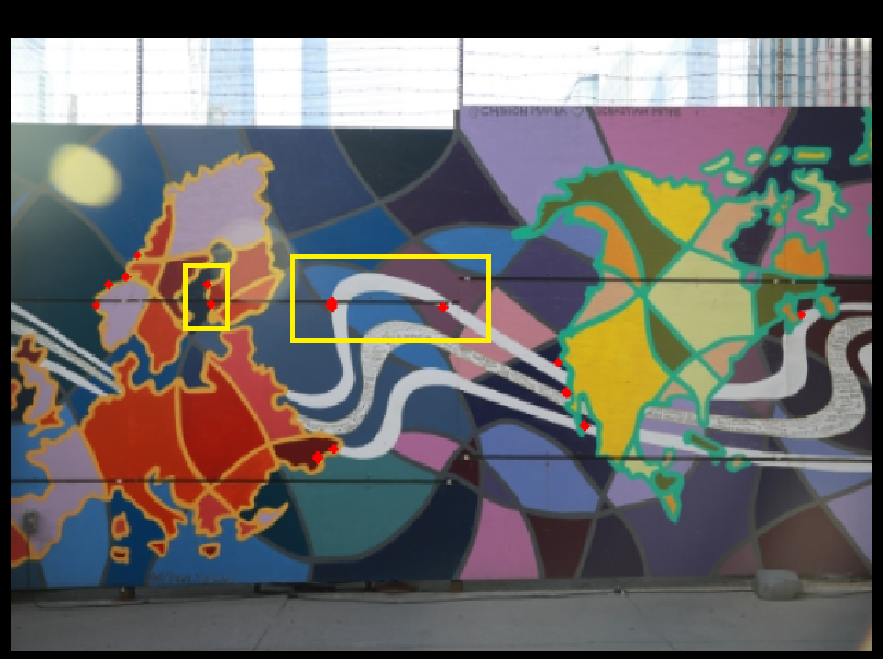

#7.2. Scene stitching with SIFT/SURF features

##7.2.1

In [14]:
def match_2image(img1, img2):
  # Create SIFT instance
  sift = cv2.xfeatures2d.SIFT_create()

  # Run SIFT on both images
  keypoints_l, descriptors_l = sift.detectAndCompute(img1, None)
  keypoints_r, descriptors_r = sift.detectAndCompute(img2, None)

  # Feature matching
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
  matches = bf.match(descriptors_l, descriptors_r)
  matches = sorted(matches, key=lambda x:x.distance)
  # Draw matches
  matches_img = cv2.drawMatches(
      img1, keypoints_l,
      img2, keypoints_r,
      matches[:30],
      None,
      flags=2, # Disable drawing single key points
  )
  imshow(matches_img)
  # merge(img1,img2, matches, keypoints_l, keypoints_r)

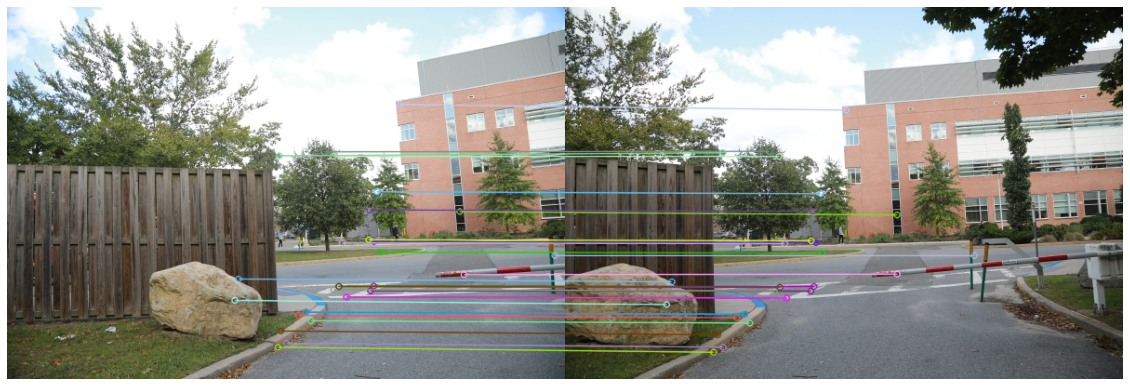

In [15]:
match_2image(Sl, Sm)

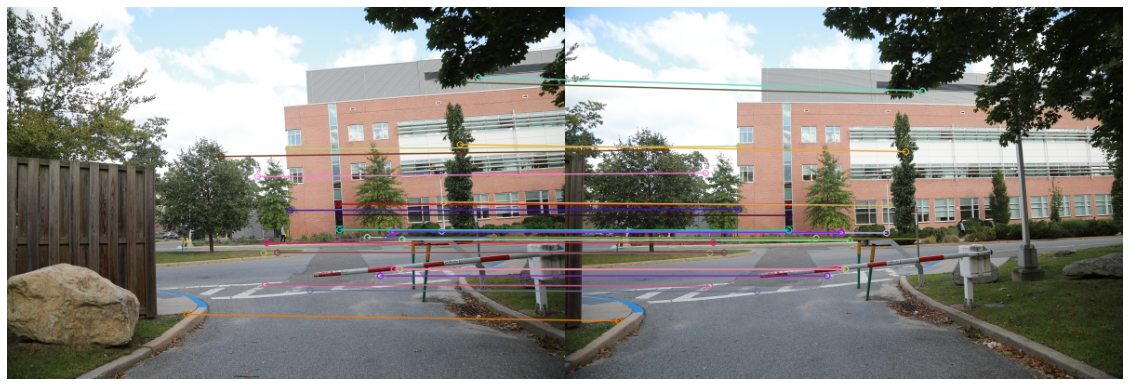

In [16]:
match_2image(Sm,Sr)

###Result

only robust features are detected by using feature descriptors.  Keypoints are extracted by the SIFT detector and their descriptors are computed by the SIFT descriptor. 

#7.2.2

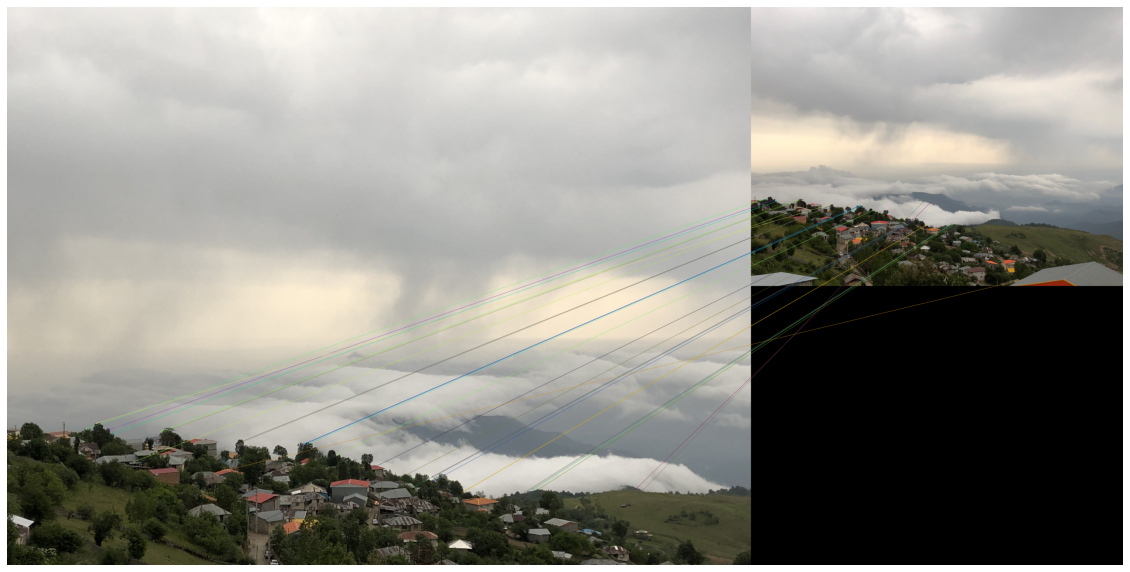

In [37]:
match_2image(three, two)

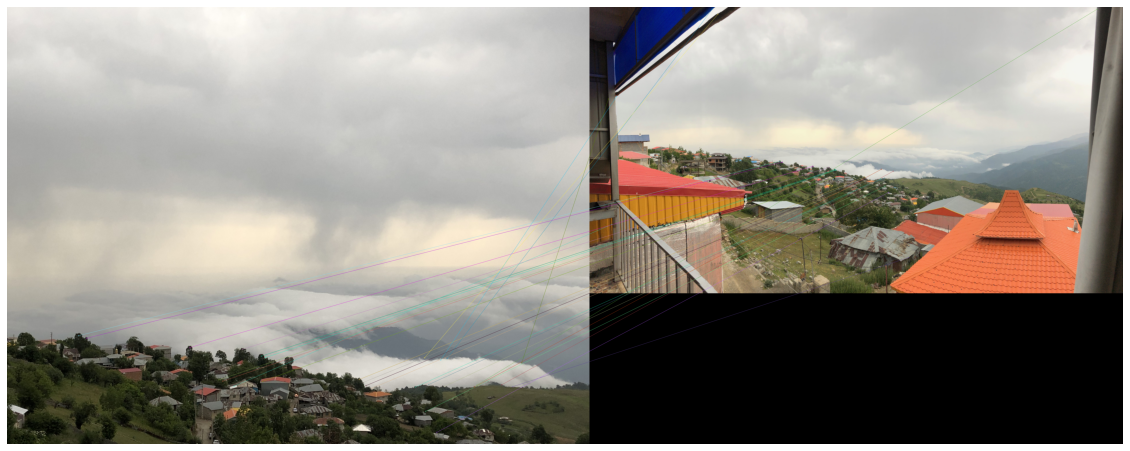

In [38]:
match_2image(three, one)

###Result

SIFT is robust to the image rotation, affine transformations, intensity, and viewpoint change in matching features. 